# Fireveg DB - overview of trait coverage

Author: [José R. Ferrer-Paris](https://github.com/jrfep) and [Ada Sánchez-Mercado](https://github.com/adasanchez)

Date: January 2025

This Jupyter Notebook includes **R code to analyse and visualise** data exported from the Fireveg Database. 

Here we will read input from a public data record of the database to answer some questions about the data coverage of the database.

```mermaid
flowchart LR
    Litrev & Form  --> Fireveg --> DR --> Code --> Q1 & Q2 & Q3
    Q2 --> Q4 & Q5 & Q6
    Fireveg[(Fireveg\nDatabase)]
    Litrev[Field work\ndata stream] 
    Form[Existing sources\n data stream] 
    BioNet(BioNet Atlas\nSpecies list) 
    BioNet -.-> Fireveg
    Code{R code\nfor analysis}:::ThisRepo
    DR[Exported\nData Record\nVersion 1.1]
    Q3["Q2. ..."]
    Q2["Q3. ..."]:::ThisRepo
    Q1["Q1. ..."]    
    Q4["Q3.1 ..."]:::ThisRepo   
    Q5["Q3.2 ..."]:::ThisRepo
    Q6["Q3.3 etc."]:::ThisRepo
classDef ThisRepo fill:none,stroke:black,color:black;
```

## Set-up

### Load packages

In [1]:
library(ggplot2)
library(dplyr)
require(tidyr)
library(readr)
library(stringr)
library(waffle)
library(ggtext)
library(cowplot)
library(readxl)    # For reading data in Excel format
library(forcats)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr



For [Markdown display from a code cell](https://stackoverflow.com/questions/35786496/using-r-in-jupyter-display-markdown-in-loop?rq=4).

In [2]:
library(IRdisplay)

### Paths for inputs and outputs

Locate the root directory of the repo

In [4]:
here::i_am("Notebooks/23-Overview-field-metrics.ipynb")

here() starts at /Users/z3529065/proyectos/fireveg/fireveg-analysis



Relative path to local data files within project repository

In [5]:
data_dir <- here::here("data")
if (!dir.exists(data_dir))
    dir.create(data_dir)

### Read data from local folder

<div class="alert alert-info">
     <img src='../img/open-data-2.png' width=25 alt="open data icon"/>
Data for this Notebook is available from the following repositories:

> Ferrer-Paris, J. R., Keith, D., & Sánchez-Mercado, A. (2024, August 15). Export data records from Fire Ecology Traits for Plants database. Retrieved from [osf.io/h96q2](https://osf.io/h96q2/)

and 
> Ferrer-Paris, J. R.; Keith, D. (2024). Fire Ecology Traits for Plants: Database exports. figshare. Dataset. Retrieved from <https://doi.org/10.6084/m9.figshare.24125088.v2>
</div>

See notebook [00-Data-download](00-Data-download.ipynb) for instructions on how to download the data programatically with R.

The data is now available in our local data folder and we can use `read_csv` functions to read `CSV` files:

In [6]:
field_records <- read_csv(here::here(data_dir, "figshare_data", "fireveg-field-records.csv"), 
                          col_types = "dcDdcddccddddddddccc")

New names:
• `` -> `...1`


In [7]:
head(field_records)

...1,visit_id,visit_date,sample_nr,species,species_code,bionet_code,resprout_organ,seedbank,adults_unburnt,resprouts_live,resprouts_died,resprouts_kill,resprouts_reproductive,recruits_live,recruits_reproductive,recruits_died,scorch,life_stage,comments
<dbl>,<chr>,<date>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0,AlpAsh_18,2021-04-15,1,Cassinia aculeata,1360,1360,None,Soil-persistent,0,0,0,NA,0,1,0,0,NA,NA,"['Imported from workbook UNSW_VegFireResponse_KNP AlpAsh_firehistupdate.xlsx using python script', 'Imported from spreadsheet Floristics', 'seedbank written as persistent soil']"
1,AlpAsh_18,2021-04-15,1,Olearia erubescens,1591,1591,Basal,Non-canopy,0,31,0,NA,0,0,0,0,NA,NA,"['Imported from workbook UNSW_VegFireResponse_KNP AlpAsh_firehistupdate.xlsx using python script', 'Imported from spreadsheet Floristics']"
2,AlpAsh_18,2021-04-15,1,Daviesia ulicifolia,2827,2827,Basal,Soil-persistent,0,1,0,NA,0,0,0,0,NA,NA,"['Imported from workbook UNSW_VegFireResponse_KNP AlpAsh_firehistupdate.xlsx using python script', 'Imported from spreadsheet Floristics', 'seedbank written as persistent soil']"
3,AlpAsh_18,2021-04-15,1,Gonocarpus montanus,3244,3244,NA,Soil-persistent,0,0,0,NA,0,6,0,0,NA,NA,"['Imported from workbook UNSW_VegFireResponse_KNP AlpAsh_firehistupdate.xlsx using python script', 'Imported from spreadsheet Floristics', 'seedbank written as persistent soil']"
4,AlpAsh_18,2021-04-15,1,Arthropodium milleflorum,3517,3517,Tuber,Transient,0,70,0,NA,70,NA,NA,NA,NA,NA,"['Imported from workbook UNSW_VegFireResponse_KNP AlpAsh_firehistupdate.xlsx using python script', 'Imported from spreadsheet Floristics']"
5,AlpAsh_18,2021-04-15,1,Acacia obliquinervia,3837,3837,Basal,Soil-persistent,0,2,0,NA,0,10,0,0,NA,NA,"['Imported from workbook UNSW_VegFireResponse_KNP AlpAsh_firehistupdate.xlsx using python script', 'Imported from spreadsheet Floristics', 'seedbank written as persistent soil']"


Use `read_excel` to read files in `XLSX` format:

In [8]:
sites_record <- read_excel(here::here(data_dir, "figshare_data","fireveg-field-report-model.xlsx"), sheet = 2)

## Fire history
Filter only sites burnt less than three years ago

In [9]:
last_fire <- sites_record |>
  mutate(last_fire = case_when(
      `Time since last fire (days)` %in% c(NA,"0 days","ERROR: mismatching dates") ~ 'unknown',
      !grepl("year", `Time since last fire (days)`) ~ 'recent',
      grepl("^(2 years|3 years|1 year)", `Time since last fire (days)`) ~ 'recent',
      TRUE ~ "older"
  )) |>
  select(`Survey`,`Site label`, `Visit date`, `Time since last fire (days)`, "last_fire")  |>
  rename(visit_id = `Site label`, visit_date = `Visit date`)

In [10]:
last_fire |> slice_sample(n=5)

Survey,visit_id,visit_date,Time since last fire (days),last_fire
<chr>,<chr>,<dttm>,<chr>,<chr>
NEWNES,GGW2,2021-04-20,1 years and 126 days,recent
NEWNES,HV1,2021-04-06,1 years and 112 days,recent
Yatteyattah,SZ23101,2021-02-24,51 days,recent
NEWNES,HV1,2020-11-25,345 days,recent
Mallee Woodlands,T2011/4,2013-09-22,2 years and 18 days,recent


In [11]:
sites_record |> slice_sample(n=5)

Survey,Site label,Location,Coordinates (WGS84),Elevation,Visit date,Visit description,Main observer,All observers,Time since last fire (days)
<chr>,<chr>,<chr>,<chr>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>
NEWNES,MW1,NA,150.191 -33.414,1093,2020-03-06,NA,"None, None",David Keith,81 days
Mallee Woodlands,T2017/2,"Tarawi Nature Reserve, NW corner of Jim Noble's block 800 m south of T2017/1. Burnt 1984.",141.167 -33.356,NA,2017-03-27,NA,"Keith, David",David Keith,33 years and 34 days
Alpine Bogs,AUSALPS_NSW198,Small gully N of and parallel to Happy Jacks Rd at 1st drainage line crossing from east side of HJ Plain,148.518 -36.051,1450,2021-03-02,NA,"Miles, Jackie",Jackie Miles,1 years and 31 days
Mallee Woodlands,S2007/5,"Scotia Sanctuary, southwestern sector, South of Robinsons Dam firetrail, core of burnt area",141.062 -33.310,NA,2011-08-27,NA,"Keith, David",David Keith,5 years and 300 days
Rainforests NSW-Qld,BC_1_UNSW,"Bishop's Creek, New England NP, low fire impact",152.633 -30.426,NA,2021-08-04,NA,"Kooyman, Robert",Robert Kooyman,0 days


In [28]:
# 3. Calculate traits by species -----
# Number of individuals with a given trait. All the spp in the datset
full_spp_trait <- field_records |>
    filter(!is.na(species_code)) |>
  mutate(spp_type = case_when(
    resprout_organ %in% c("None") ~ "Seeder", 
    TRUE ~ "Resprouter")
  ) |>
 # left_join(species_list, by = c("species" = "Scientific name (as entered)")) |> # Add family information
 # left_join(distinct(species_list), by = c("species_code" = "CAPS code")) |> # Add family information
  left_join(last_fire, by = c("visit_id","visit_date")) |>  # Add fire information
  filter(last_fire == "recent") |> # Calculate the metrics only for these sites with time since last fire <= 3 years
  group_by(species, Survey, visit_id, visit_date, spp_type) |>
  summarise(n1 = sum(resprouts_live, na.rm = TRUE),         # N total live resprouts (N1)
            n2 = sum(resprouts_reproductive, na.rm = TRUE), # N reproductive live resprouts (N2)
            n5 = sum(recruits_live, na.rm = TRUE),          # N total live recruits (N5)
            n6 = sum(recruits_reproductive, na.rm = TRUE),  # N reproductive live recruits (N6)
            n7 = sum(resprouts_died, na.rm = TRUE),         # N Dead resprouts (N7). This variable is all 0
            n8 = sum(recruits_died, na.rm = TRUE),          # N dead recruits (N8)
            n9 = sum(resprouts_kill, na.rm = TRUE),      # N fire killed resprouts (N9)
            .groups = "drop"
) |>
  mutate(prop_fire_mortality = n9 /(n1 + n7 + n9),
         prop_sprout_surv = n7/ (n1 + n7),
         seed_adult = (n5 + n8) / (n1 + n7),
         pro_recruit_surv = n5 / (n5 + n8),
         prop_reprod_recruit = n6 / max(n5)
  ) |>
  as_tibble() 


In [38]:

# 4. Select the top 20 spp ----
# Species with more localities and plots
top_species <- full_spp_trait |>
    filter(Survey %in% "Mallee Woodlands") |>
  group_by(species) |>
  summarise(
    n_localities = n_distinct(visit_id),
    n_visits = n_distinct(visit_id,visit_date)
  ) |>
arrange(desc(n_localities)) |>
slice_head(n=10) |> pull(species)


In [39]:
full_spp_trait |>   filter(species %in% top_species, !is.na(prop_fire_mortality))

species,Survey,visit_id,visit_date,spp_type,n1,n2,n5,n6,n7,n8,n9,prop_fire_mortality,prop_sprout_surv,seed_adult,pro_recruit_surv,prop_reprod_recruit
<chr>,<chr>,<chr>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Eremophila glabra,Mallee Woodlands,T2005/1,2007-03-18,Resprouter,18,0,0,0,0,1,0,0.00000000,0,0.05555556,0.0000000,0
Eremophila glabra,Mallee Woodlands,T2005/3,2007-03-17,Resprouter,9,0,0,0,0,0,0,0.00000000,0,0.00000000,NaN,0
Eremophila glabra,Mallee Woodlands,T2005/4,2007-03-16,Resprouter,16,0,0,0,0,0,0,0.00000000,0,0.00000000,NaN,0
Eremophila glabra,Mallee Woodlands,T2006/1,2008-02-25,Resprouter,13,0,0,0,0,0,0,0.00000000,0,0.00000000,NaN,0
Eremophila glabra,Mallee Woodlands,T2006/2,2008-02-25,Resprouter,7,0,0,0,0,0,0,0.00000000,0,0.00000000,NaN,0
Eucalyptus socialis,Mallee Woodlands,S2012/1,2014-10-25,Resprouter,1,17,0,0,0,0,0,0.00000000,0,0.00000000,NaN,0
Eucalyptus socialis,Mallee Woodlands,S2012/6,2014-10-24,Resprouter,1,8,0,0,0,0,0,0.00000000,0,0.00000000,NaN,0
Eucalyptus socialis,Mallee Woodlands,T2005/1,2007-03-18,Resprouter,4,1,0,0,0,0,0,0.00000000,0,0.00000000,NaN,0
Eucalyptus socialis,Mallee Woodlands,T2005/3,2007-03-17,Resprouter,9,2,1,0,0,0,1,0.10000000,0,0.11111111,1.0000000,0


In [130]:
slc_spp_trait <- full_spp_trait |>
    filter(species %in% top_species) |>
    mutate(species = fct_reorder(species, ifelse(spp_type == "Seeder", 2,1)))

In [158]:

pfm <- 
ggplot(slc_spp_trait, aes(x = prop_fire_mortality, fill=spp_type)) +
geom_histogram( bins = 8) +
facet_grid(~species, 
           labeller = labeller(species = label_wrap_gen(10))) +
labs(x="Proportion Fire Mortality", y = "Number of samples") +
theme_classic() +
theme(legend.position = "none",
     panel.border = element_rect(fill = "transparent", # Needed to add the border
                                    color = "black", linewidth = 0.5))

In [159]:
prs <- 
ggplot(slc_spp_trait, aes(x = pro_recruit_surv, fill=spp_type)) +
geom_histogram( bins = 8) +
facet_grid(~species) +
labs(x="Proportion Recruit Survival", y = "Number of samples")+
theme_classic() +
theme(legend.position = "none", strip.text=element_blank(),
     panel.border = element_rect(fill = "transparent", # Needed to add the border
                                    color = "black", linewidth = 0.5))

In [160]:
prr <- 
ggplot(slc_spp_trait, aes(x = prop_reprod_recruit, fill=spp_type)) +
geom_histogram( bins = 8) +
facet_grid(~species) +
labs(x="Proportion of Reproductive Recruits", y = "Number of samples")+
theme_classic() +
theme(legend.position = "none", strip.text=element_blank(),
     panel.border = element_rect(fill = "transparent", # Needed to add the border
                                    color = "black", linewidth = 0.5))

Warning message:
“Removed 250 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 44 rows containing non-finite outside the scale range (`stat_bin()`).”


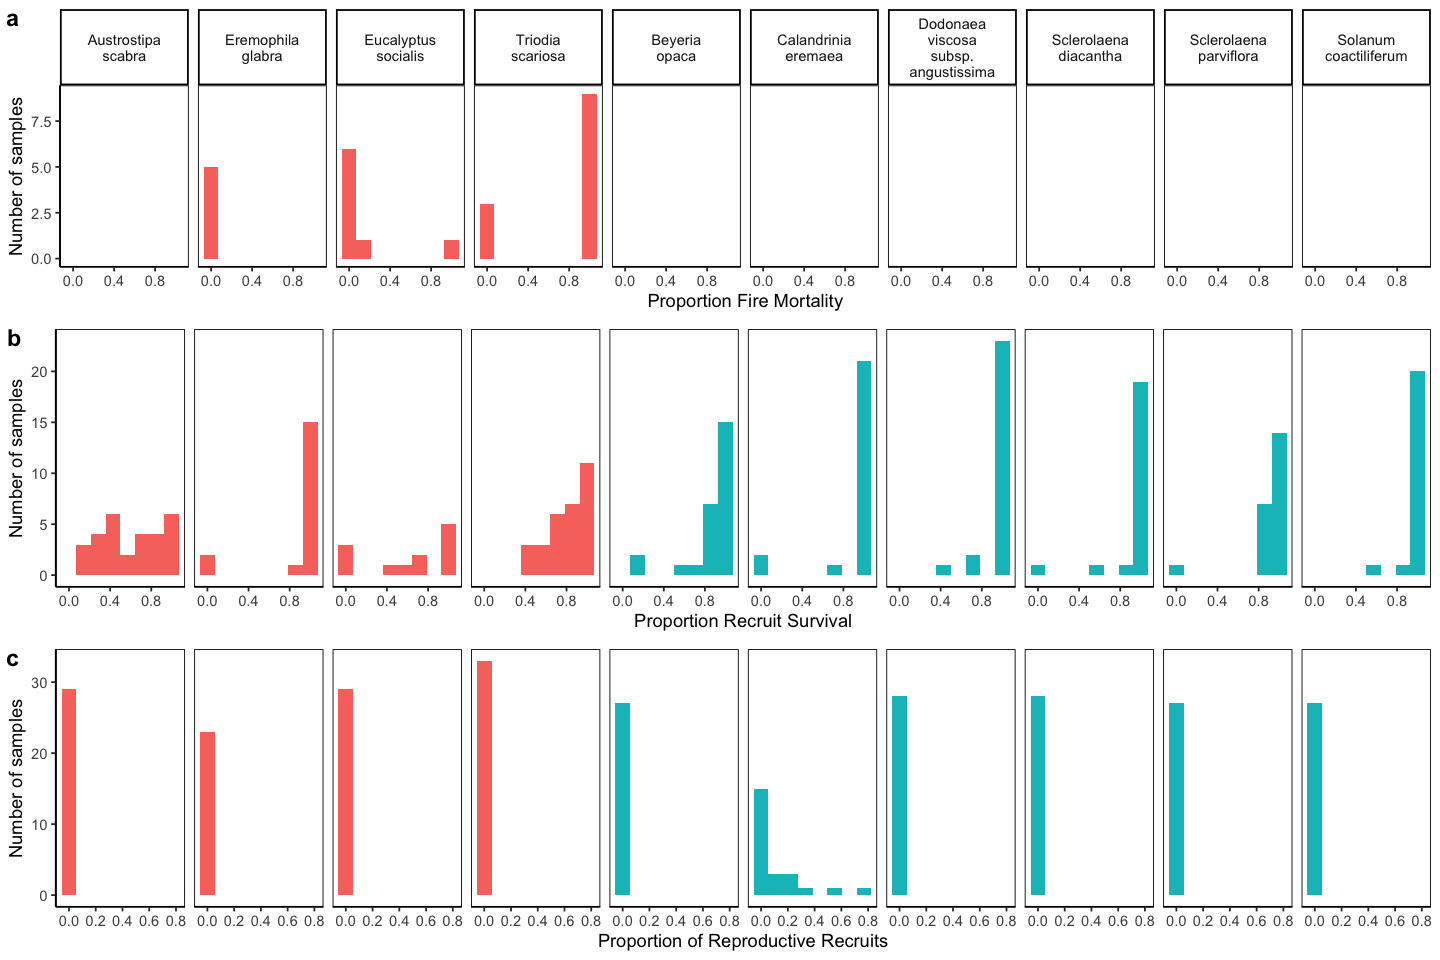

In [162]:
options(repr.plot.width=12, repr.plot.height=8) # Make plot larger
plot_grid(pfm, prs, prr, 
           #align = "vh",
          labels = "auto",
         ncol = 1)

In [157]:
full_spp_trait |> slice_sample(n=5)

species,Survey,visit_id,visit_date,spp_type,n1,n2,n5,n6,n7,n8,n9,prop_fire_mortality,prop_sprout_surv,seed_adult,pro_recruit_surv,prop_reprod_recruit
<chr>,<chr>,<chr>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Clematis aristata,UplandBasalt,Sassafras 3,2021-02-20,Resprouter,6,0,0,0,0,0,0,0,0,0,NaN,0.000000e+00
Sclerolaena diacantha,Mallee Woodlands,S2012/7,2013-09-28,Seeder,0,0,6,5,0,0,0,NaN,NaN,Inf,1,6.859557e-05
Eucalyptus costata,Mallee Woodlands,T2005/2,2007-03-19,Resprouter,0,9,1,0,0,0,0,NaN,NaN,Inf,1,0.000000e+00
Maireana georgei,Mallee Woodlands,S2011/1,2013-09-26,Seeder,0,0,2,0,0,0,0,NaN,NaN,Inf,1,0.000000e+00
Pteridium esculentum,UplandBasalt,CRN36B7S,2021-02-02,Resprouter,86,0,0,0,0,0,0,0,0,0,NaN,0.000000e+00


In [38]:
full_spp_trait |> count(spp_type)
full_spp_trait |> count(seedbank)
full_spp_trait |> count(resprout_organ)
full_spp_trait |> count(Family)
full_spp_trait |> count(last_fire)

spp_type,n
<chr>,<int>
Resprouter,2520
Seeder,1168


seedbank,n
<chr>,<int>
Canopy,268
Non-canopy,1156
Soil-persistent,1760
Transient,185
NA,319


resprout_organ,n
<chr>,<int>
Apical,18
Basal,289
Epicormic,73
Lignotuber,208
None,1168
Short rhizome,40
Stolon,124
Tuber,142
Tussock,250


Family,n
<chr>,<int>
Acanthaceae,3
Aizoaceae,1
Amaranthaceae,18
Anthericaceae,25
Aphanopetalaceae,2
Apiaceae,57
Apocynaceae,28
Araceae,1
Araliaceae,19


last_fire,n
<chr>,<int>
recent,3688


In [286]:
filter(field_records, visit_date<"2019-01-01") |>
group_by(species) |>
summarise(nsites = n_distinct(visit_id),
          nvisits = n_distinct(visit_id,visit_date),
         nplots = n_distinct(visit_id,visit_date,sample_nr)) |>
arrange(desc(nvisits)) |>
slice_head(n=15)

species,nsites,nvisits,nplots
<chr>,<int>,<int>,<int>
Triodia scariosa,58,82,452
Austrostipa scabra,60,79,386
Beyeria opaca,51,69,335
Sclerolaena diacantha,52,69,306
Eucalyptus socialis,49,68,300
Dodonaea viscosa subsp. angustissima,45,63,217
Sclerolaena parviflora,44,61,271
Eremophila glabra,44,57,172
Eucalyptus dumosa,40,55,212


In [287]:
filter(field_records, visit_date > "2019-01-01") |>
group_by(species) |>
summarise(nsites = n_distinct(visit_id),
          nvisits = n_distinct(visit_id,visit_date),
         nplots = n_distinct(visit_id,visit_date,sample_nr)) |>
arrange(desc(nvisits)) |>
slice_head(n=15)

species,nsites,nvisits,nplots
<chr>,<int>,<int>,<int>
Microlaena stipoides,31,31,56
Clematis aristata,28,28,57
Pteridium esculentum,28,28,50
Conyza sumatrensis,27,27,70
Hydrocotyle hirta,27,27,53
Smilax australis,27,27,57
Acacia melanoxylon,26,26,58
Geranium homeanum,26,26,43
Dichondra repens,25,25,44


In [291]:
spp_selection <- "Sclerolaena diacantha"
spp_selection <- "Microlaena stipoides"


datos_spp1 <- field_records |> 
    filter(species %in% spp_selection) |>
      group_by(visit_id, visit_date) |>
      summarise(n1 = sum(resprouts_live, na.rm = TRUE),         # N total live resprouts (N1)
                n2 = sum(resprouts_reproductive, na.rm = TRUE), # N reproductive live resprouts (N2)
                n5 = sum(recruits_live, na.rm = TRUE),          # N total live recruits (N5)
                n6 = sum(recruits_reproductive, na.rm = TRUE),  # N reproductive live recruits (N6)
                n7 = sum(resprouts_died, na.rm = TRUE),         # N Dead resprouts (N7)
                n8 = sum(recruits_died, na.rm = TRUE),          # N dead recruits (N8)
                n9 = sum(resprouts_kill, na.rm = TRUE),         # N fire killed resprouts (N9)
                .groups = "drop") |>
  mutate(n_fire_mortality = n1 + n7 + n9,
         prop_fire_mortality = n9 /(n1 + n7 + n9),
         n_sprout_surv = n1 + n7,
         prop_sprout_surv = n7/ (n1 + n7),
         seed_adult = (n5 + n8) / (n1 + n7),
         n_recruit_surv = n5 + n8,
         pro_recruit_surv = n5 / (n5 + n8),
         n_reprod_resprod = n1,
         n_reprod_recruit = n6, # the formula said N5 but this is the number of lives recruits
         prop_reprod_recruit = n6 / max(n5),
         surv_dens = n2 / 625, # plot area
         recruit_dens = n5 / 625 # plot area
         )

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 31 rows containing non-finite outside the scale range (`stat_bin()`).”


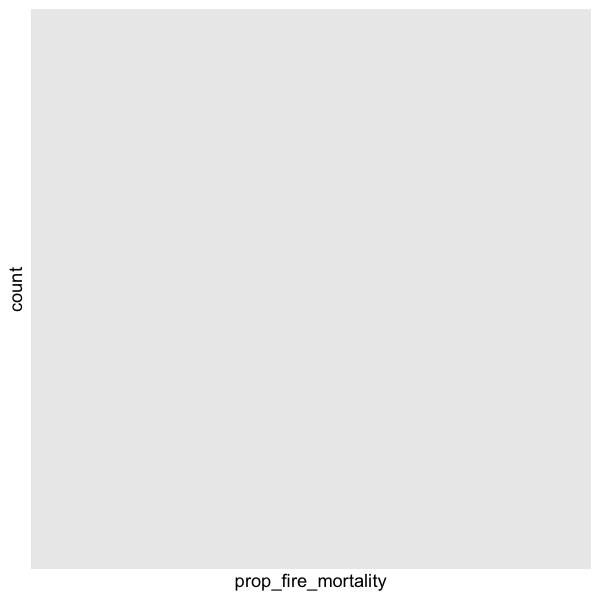

In [294]:
options(repr.plot.width=5, repr.plot.height=5) 
ggplot(datos_spp1) +
geom_histogram(aes(x=prop_fire_mortality))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_bin()`).”


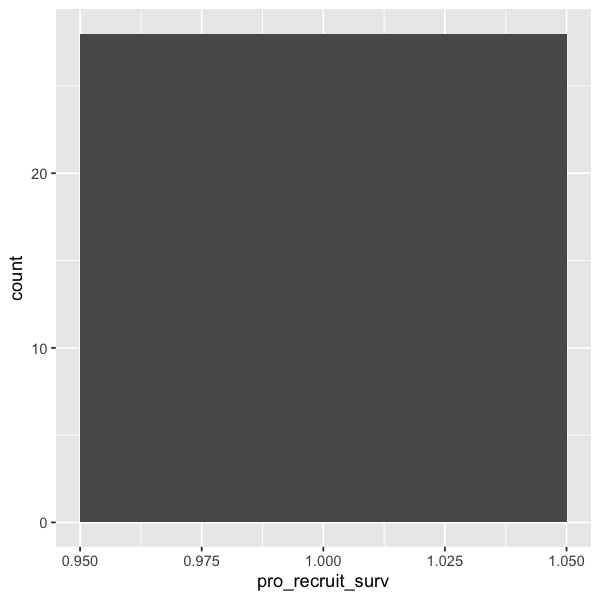

In [292]:
options(repr.plot.width=5, repr.plot.height=5) 
ggplot(datos_spp1) +
geom_histogram(aes(x=pro_recruit_surv))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


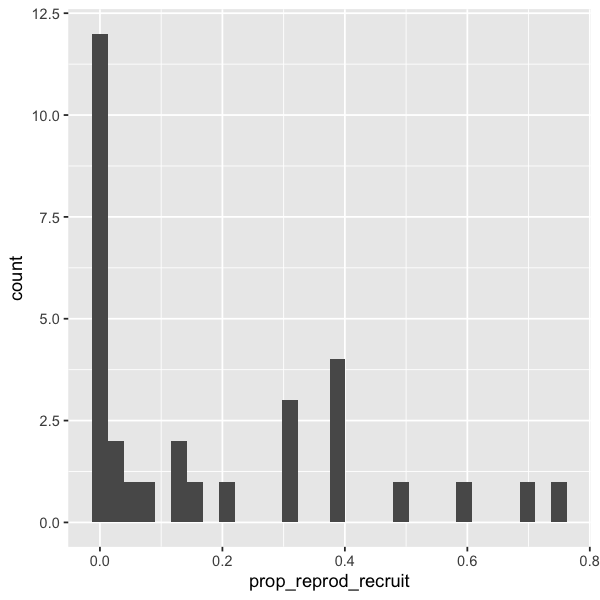

In [293]:
options(repr.plot.width=5, repr.plot.height=5) 
ggplot(datos_spp1) +
geom_histogram(aes(x=prop_reprod_recruit))

In [85]:
surv6_data

...1,scientific name,current code (BioNET),original name,CAPS code,trait code,trait name,method,weight,source ref,other ref,recordid,bound,value
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>


We will now look at how many species from the NSW BioNet Atlas are represented in the fireveg database. First let's take a look at the NSW flora, and then we will query how many species have information about fire ecology traits from existing sources or field work. We will combine this information in the final subsection.

#### Field work data

Next, we look at the taxa represented in the field work data. How many species have at least one record in the field sample?

In [23]:
spp_traits_table |>
    filter(`Field samples`) |>
    group_by(`species level`= taxonrank %in% "Species",establishment) |>
    summarise(records=n(), `original names` = n_distinct(spp), `current names`=n_distinct(current_species), .groups = "drop") 

species level,establishment,records,original names,current names
<lgl>,<chr>,<int>,<int>,<int>
FALSE,"Alive in NSW, Native",68,68,68
FALSE,Introduced,2,2,2
TRUE,"Alive in NSW, Native",812,812,806
TRUE,Introduced,84,84,81


In order to get more detailed break down of numbers, we use the `quadrat_samples` data frame:

In [24]:
quadrat_samples |> 
    filter(!is.na(species_code),
           taxonrank %in% "Species") |>
    group_by(survey_name) |>
    summarise(
        locations = n_distinct(visit_id),
        visits  = n_distinct(visit_id, visit_date),
        samples  = n_distinct(visit_id, visit_date, sample_nr),
        records = n(), 
        species = n_distinct(species),
        current_species = n_distinct(current_species), 
        codes = n_distinct(species_code))

survey_name,locations,visits,samples,records,species,current_species,codes
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Alpine Bogs,6,6,120,1435,109,109,109
KNP AlpAsh,8,8,32,593,85,85,85
Mallee Woodlands,61,85,510,7054,129,129,129
NEWNES,20,20,383,2950,109,109,109
Rainforests NSW-Qld,10,10,60,1503,271,270,271
Robertson RF,2,2,8,207,51,51,51
SthnNSWRF,4,4,15,162,67,67,67
TO BE CLASSIFIED,3,3,11,374,128,127,128
UplandBasalt,27,27,80,1454,231,230,231


The Mallee Woodlands survey is a longer time series of observation in a single region in Western New South Wales, while all the other surveys represent samples completed after the 2019-2020 fires in Eastern New South Wales. We will calculate summary statistics for these two groups:

In [25]:
summary_per_survey <- quadrat_samples |> 
    filter(!is.na(species_code),
           taxonrank %in% "Species") |>
    group_by(survey_group=survey_name %in% "Mallee Woodlands") |>
    summarise(
        locations = n_distinct(visit_id),
        visits  = n_distinct(visit_id, visit_date),
              samples  = n_distinct(visit_id, visit_date, sample_nr),
              records = n(), 
              species = n_distinct(species),
              current_species = n_distinct(current_species), 
              codes = n_distinct(species_code)) |> 
    arrange(survey_group)

In [26]:
summary_per_survey

survey_group,locations,visits,samples,records,species,current_species,codes
<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
FALSE,85,85,714,8936,773,765,773
TRUE,61,85,510,7054,129,129,129


## That is it for now!

✅ Job done! 😎👌🔥

You can:
- go [back home](../Instructions-and-workflow.ipynb),
- continue navigating the repo on [GitHub](https://github.com/ces-unsw-edu-au/fireveg-analysis)
- continue exploring the repo on [OSF](https://osf.io/h96q2/).
- visit the database at <http://fireecologyplants.net>